# STDSR23 - Assignment-01

> Dautov Almaz
# Quantile implementation

February 2023

## Assignment description

* Obtain the research paper titled ["A Survey of Approximate Quantile Computation on Large-Scale Data"](https://arxiv.org/pdf/2004.08255.pdf)

* Select and implement one of the methods discussed in the paper, following good coding style and with appropriate comments. Your algorithm can be based on `BasicQuantileAlgorithm` class. In that case, your main implementation is in the `compute_quantile` function.
* Prepare a report that includes
    * A detailed explanation of the selected algorithm
    * A listing of the pros and cons of the chosen algorithm
* Test your implementation. More on that below in section `Test`.
* Submit Jupyter Notebook *.ipynb* to the Moodle

Note: Code style, comments, and overall organization of the report will be
taken into account in the grading process.


## Abstract implementation

Can be used as a basic class for your implementation

In [1]:
from typing import List

class BasicQuantileAlgorithm:
    """
    Abstract class for quantile computing algorithm
    """
    
    def __init__(self) -> None:
        """
        Initializer for algorithm
        """
    
    def compute_quantile(self, q) -> float:
        """
        Implementation of some quantile algorithm
        """
        raise NotImplementedError('compute_quantile is not implemented')
    
    def compute(self, q) -> float:
        assert 0.0 <= q <= 1.0, f"q should be in [0;1]. Got {q}"
        """
        Compute the q-th quantile
        
        Hides implementation of _compute_quantile. 
        
        :param q: Quantile to compute, which must be between 0 and 1 inclusive
        :return: q-th quantile
        """
        return self.compute_quantile(q)
    
    # NOTE: multi_compute is just a basic function
    # for computing multiple quantile with one function call. 
    # This can be modified, so that multiple quantiles
    # calculation become efficient. 
    def multi_compute(self, qs) -> List[float]:
        """
        Compute multiple q-th quantiles
        
        :param qs: list of quantiles to compute, 
            all should be between 0 and 1 inclusive|
        :return: list of computed quantiles
        """
        return [self.compute(q) for q in qs]

This is just an example of the algorithm implementation.

In [2]:
import numpy as np

class NumpyQuantileAlgorithm(BasicQuantileAlgorithm):
    """
    Example of quantile algorithm
    
    This algorithm implementation is 
    based on the numpy.quantile. 
    """
    def __init__(self):
        """
        Initializer of the class. 
        
        It initializes self.data with empty list
        """
        self.data = []
    
    def add_item(self, item):
        """
        Adds an item to the existing data
        """
        self.data.append(item)
    
    def add_multiple_items(self, items):
        """
        Adds multiple items to the existing data
        """
        self.data += items
    
    def compute_quantile(self, q) -> float:
        """
        Compute the q-th quantile
        
        :param q: Quantile to compute, which must be between 0 and 1 inclusive
        :return: q-th quantile
        """
        return np.quantile(self.data, q)
    
    # NOTE: Here, for multi_compute we
    # can just call the same function
    # compute_quantile, because it could
    # take a vector of multiple quantiles.
    # This is more efficient, than basic 
    # function call, because of the 
    # vectorized implementation.
    def multi_compute(self, qs) -> List[float]:
        """
        Compute multiple q-th quantiles
        
        :param qs: list of quantiles to compute, 
            all should be between 0 and 1 inclusive
        :return: list of computed quantiles
        """
        return list(self.compute_quantile(qs))

In [3]:
## YOUR IMPLEMENTATION HERE
from math import log2, ceil, isqrt
from collections import Counter
from functools import cmp_to_key

class QDigestNode:
    '''
    The QDigestNode class represents a single node in the Q-Digest tree, 
    which stores information about a range of values and the count of values falling 
    within that range.
    '''
    
    def __init__(self, minimum, maximum, count = 0):

        #minimum value of the range represented by this node
        self.minimum = minimum

        #the maximum value of the range represented by this node
        self.maximum = maximum

        #the count of values falling within the range represented by this node
        self.count = count

class QDigest(BasicQuantileAlgorithm):
    def __init__(self, data):

        #Dictionary that stores the nodes of the Q-Digest tree. The keys are indices in the tree, and the values are QDigestNode.
        self.Hashmap = {}

        #List of tuples that represent the nodes in the Q-Digest tree that have been compressed.
        self.representation = []

        #Maximum value in the range of values being represented by the Q-Digest.
        self.range_max = max(data)

        #Minimum value in the range of values being represented by the Q-Digest.
        self.range_min = min(data)

        #Total count of data points in the range being represented by the Q-Digest.
        self.n = len(data)
        
        #Compression constant of the Q-Digest tree.
        self.k = isqrt(self.n)
        
        #The size of the range being represented by the Q-Digest.
        self.range_size = self.range_max - self.range_min + 1

        #The number of levels in the Q-Digest.
        self.number_of_levels = ceil(log2(self.range_size))  + 1

        self.build(data)
        self.compress()

    '''
    The build method creates a hash map where the keys are indices 
    in the Q-Digest tree and the values are QDigestNode objects.
    '''

    def build(self, data):
        d = Counter(data)
        #index of most left leaf
        index = 2**(self.number_of_levels - 1) - 1
        prev = self.range_min

        for value in sorted(d):
            index += value - prev
            self.Hashmap[index] = QDigestNode(minimum= value, maximum= value, count= d[value])
            prev = value
    '''
    The merge method is used to merge two Q-digests together. 
    It takes in another Q-Digest as input and modifies the current Q-digest tree.
    '''
    def merge(self, Q):
        for key, count, left, right in self.representation:
            self.Hashmap[key] = QDigestNode(left, right, count)
        self.representation = []

        self.range_max = max(self.range_max, Q.range_max)
        self.range_min = min(self.range_min, Q.range_min)
        self.n += Q.n
        self.range_size = self.range_max - self.range_min + 1
        self.number_of_levels = ceil(log2(self.range_size))  + 1
        

        for key, count, left, right in Q.representation:
            if key in self.Hashmap:
                self.Hashmap[key].count += count
            else:
                self.Hashmap[key] = QDigestNode(left, right, count)

        self.compress()

    '''
    The add method allows to add a new element or list of elements to the Q-Digest tree.
    '''
    def add(self, arr):
        self.merge(QDigest(arr))
    '''
    Returns the sibling of the node at the specified index in the Q-Digest tree.
    '''

    def sibling(self, index):
        return index + 1 if index % 2 == 1 else index - 1
    
    '''
    Returns the parent of the node at the specified index in the Q-Digest tree.
    '''
    def parent(self, index):
        if index == 0:
            return 0
        return (index - 1) // 2
    
    '''
    Returns: 
    True, if the node at the specified index in the Q-Digest tree is a leaf node.
    False, otherwise.
    '''
    def is_leaf(self, index):
        return 2 ** (self.number_of_levels - 1) - 1 <= index < 2 ** self.number_of_levels - 1

    '''
    Returns the index of the leftmost child of the node at the specified index in the Q-Digest tree.
    '''
    def find_left_most_child(self, index):
        if self.is_leaf(index):
            return index
        return self.find_left_most_child(index * 2 + 1)
    
    '''
 
    Returns the index of the rightmost child of the node at the specified index in the Q-Digest tree.
    '''
    def find_right_most_child(self, index):
        if self.is_leaf(index):
            return index

        if index * 2 + 2 >= 2 ** (self.number_of_levels - 1) - 1 + self.range_max:
            return self.find_right_most_child(index * 2 + 1)

        return self.find_right_most_child(index * 2 + 2)

    '''
    The method of the Q-Digest tree that compresses the Q-Digest tree. It compresses nodes that doesn't satisfy the properties of Q-digest and 
    creates a new Hashmap with compressed nodes.
    '''
    def compress(self):
        l = self.number_of_levels - 1
        left_down_most = 2**l - 1

        while l > 0:
            leftmost = 2**l - 1
            for index in range(leftmost, leftmost + 2**l):
                node = self.Hashmap[index] if index in self.Hashmap else None
                node_sibling = self.Hashmap[self.sibling(index)] if self.sibling(index) in self.Hashmap else None
                node_parent = self.Hashmap[self.parent(index)] if self.parent(index) in self.Hashmap else None

                node_count = node.count if node is not None else 0
                sibling_count = node_sibling.count if node_sibling is not None else 0
                parent_count = node_parent.count if node_parent is not None else 0

                if (node_count + sibling_count + parent_count > self.n // self.k) and \
                        (node_count <= self.n / self.k or self.is_leaf(index)):
                    pass

                else:
                    index_left_most = self.find_left_most_child(self.parent(index))
                    index_right_most = self.find_right_most_child(self.parent(index))
                    left_value = index_left_most - left_down_most + self.range_min
                    right_value = index_right_most - left_down_most + self.range_min

                    self.Hashmap[self.parent(index)] = QDigestNode(left_value, right_value, node_count + sibling_count + parent_count)
                    if index in self.Hashmap:
                        del self.Hashmap[index]

                    if self.sibling(index) in self.Hashmap:
                        del self.Hashmap[self.sibling(index)]

            l -= 1
        
        #To save the memory, we store all data in the list of tuples and clear the hashtable
        def compare(x, y):
            if x[3] == y[3]:
                return abs(x[3] - x[2]) - abs(y[3] - y[2])
            return x[3] - y[3]


        for key in self.Hashmap:
            node = self.Hashmap[key]
            self.representation.append([key, node.count, node.minimum, node.maximum])

        self.representation = sorted(self.representation, key = cmp_to_key(compare))

        self.Hashmap.clear()


    '''
    The method of the Q-Digest tree that computes the quantile of rank q in the input sequence.
    '''
    def compute_quantile(self, q) -> float:
        sum = 0
        for node in self.representation:
            sum += node[1]
            if sum >=  q * self.n:
                return node[3]
        return self.representation[len(self.representation) - 1][3]

> YOUR REPORT ABOUT THE ALGORITHM

> Add comparison of the time and space consumption (with numpy algorithm). Plot them depending on the sample size or time if your algorithm is for time-series quantile calculation.

In [4]:
'''
Recursively finds size of objects
source: https://gist.github.com/durden/0b93cfe4027761e17e69c48f9d5c4118
'''

import sys
import time

def get_size(obj, seen=None):
    
    size = sys.getsizeof(obj)
    if isinstance(obj, np.ndarray):
        return obj.nbytes

    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [5]:
sample_size = [10, 100, 1000, 10000, 100000]
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]


q_digest_times = []
npQ_times = []
q_digest_mem = []
npQ_mem = []


for size in sample_size:
    data = np.random.randint(0, size, size)

    q_digest_sample_time = []
    npQ_sample_time = []
    q_digest_sample_mem = []
    npQ_sample_mem = []

    for q in quantiles:
        s_t = time.time()
        q_digest = QDigest(data)
        q_digest.compute_quantile(q)
        e_t = time.time()
        q_digest_sample_time.append(e_t - s_t)
        q_digest_sample_mem.append(get_size(q_digest))

        s_t = time.time()
        npQ = NumpyQuantileAlgorithm()
        npQ.add_multiple_items(list(data))
        npQ.compute_quantile(q)
        e_t = time.time()
        npQ_sample_time.append(e_t - s_t)
        npQ_sample_mem.append(get_size(npQ))

    q_digest_times.append(np.mean(q_digest_sample_time))
    npQ_times.append(np.mean(npQ_sample_time))
    q_digest_mem.append(np.mean(q_digest_sample_mem))
    npQ_mem.append(np.mean(npQ_sample_mem))


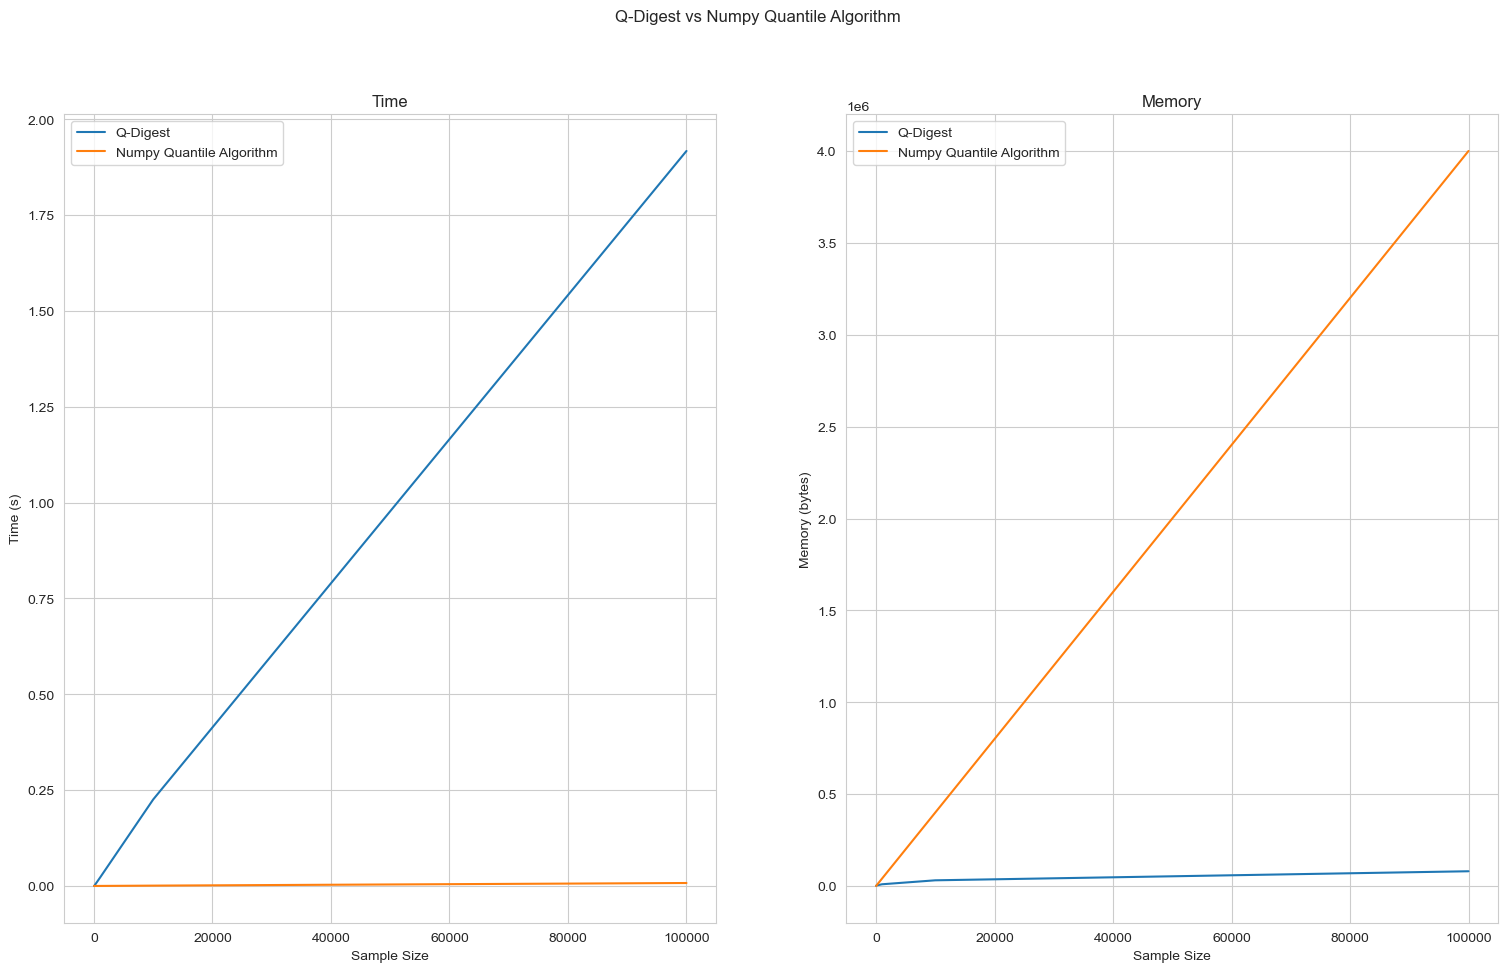

In [6]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Q-Digest vs Numpy Quantile Algorithm')
ax1.plot(sample_size, q_digest_times, label = 'Q-Digest')
ax1.plot(sample_size, npQ_times, label = 'Numpy Quantile Algorithm')
ax1.set_xlabel('Sample Size')
ax1.set_ylabel('Time (s)')
ax1.set_title('Time')
ax1.legend()

ax2.plot(sample_size, q_digest_mem, label = 'Q-Digest')
ax2.plot(sample_size, npQ_mem, label = 'Numpy Quantile Algorithm')
ax2.set_xlabel('Sample Size')
ax2.set_ylabel('Memory (bytes)')
ax2.set_title('Memory')
ax2.legend()

## Test

Here you need to show that your algorithm is working properly.
1. Take `normal` distribution. Show, that with increase in sample size, quantiles calculated with your algorithms are become very close to the `inverse cdf` of the distribution. 

2. Perform the same experiment with any other continuous distribution (exponential, logistic, etc.)

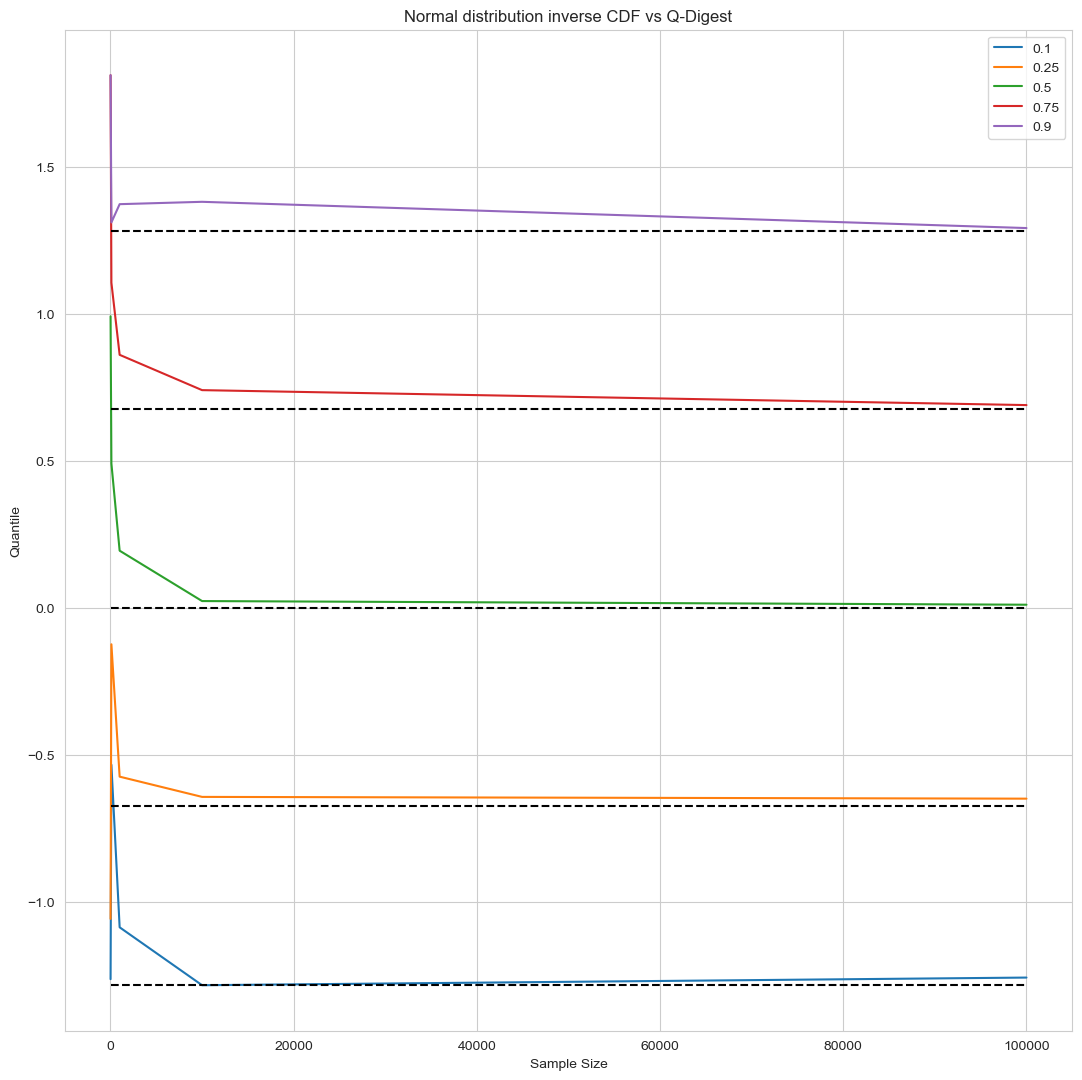

In [7]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

sample_size = [10, 100, 1000, 10000, 100000]
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

answers = [[] for i in range(len(sample_size))]

for i, size in enumerate(sample_size):
    data = (np.random.normal(0, 1, size) * 10000).astype(int)
    q_digest = QDigest(data)
    for q in quantiles:
        answers[i].append(q_digest.compute_quantile(q) / 10000)


fig, ax = plt.subplots()
fig.set_size_inches(13, 13)
ax.plot(sample_size, answers)
for q in quantiles:
    plt.plot(sample_size, np.full(shape= len(sample_size), fill_value= stats.norm.ppf(q)), label = 'Inverse CDF', color = 'black', linestyle = '--')
ax.set_xlabel('Sample Size')
ax.set_ylabel('Quantile')
ax.set_title('Normal distribution inverse CDF vs Q-Digest')
ax.legend(quantiles)

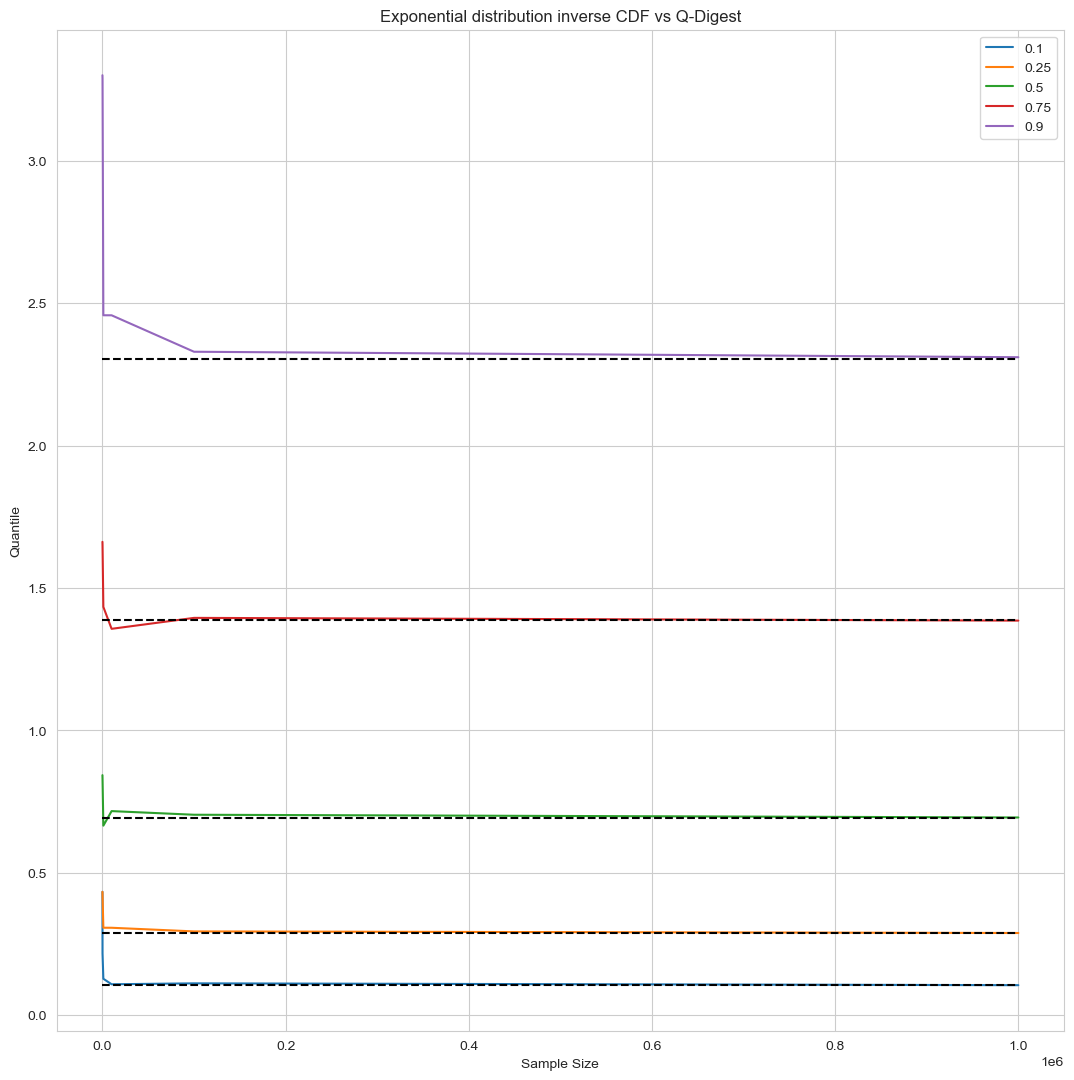

In [8]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

sample_size = [10, 100, 1000, 10000, 100000, 1000000]
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

answers = [[] for i in range(len(sample_size))]

for i, size in enumerate(sample_size):
    data = (np.random.exponential(1, size) * 10000).astype(int)
    q_digest = QDigest(data)
    for q in quantiles:
        answers[i].append(q_digest.compute_quantile(q) / 10000)

fig, ax = plt.subplots()
fig.set_size_inches(13, 13)
ax.plot(sample_size, answers)
for q in quantiles:
    plt.plot(sample_size, np.full(shape= len(sample_size), fill_value= stats.expon.ppf(q)), label = 'Inverse CDF', color = 'black', linestyle = '--')
ax.set_xlabel('Sample Size')
ax.set_ylabel('Quantile')
ax.set_title('Exponential distribution inverse CDF vs Q-Digest')
ax.legend(quantiles)

Perform an experiment that shows the main purpose of the algorithm. 

For example, some algorithms are created especially for time series data, so you should show that your algorithm is working in time series environment properly.

In [9]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

mu = 100
sigma = 30
size = 10000
N_addition = 10
rounding = 100

sizes = [size * i for i in range(1, N_addition + 1)]

answers = [[] for i in range(N_addition)]

data = (np.random.normal(mu, sigma, size) * rounding).astype(int)
q_digest = QDigest(data)

for i in range(N_addition):
    data = (np.random.normal(mu, sigma, size) * rounding).astype(int)
    q_digest.add(data)
    for q in quantiles:
        answers[i].append(q_digest.compute_quantile(q) / rounding)

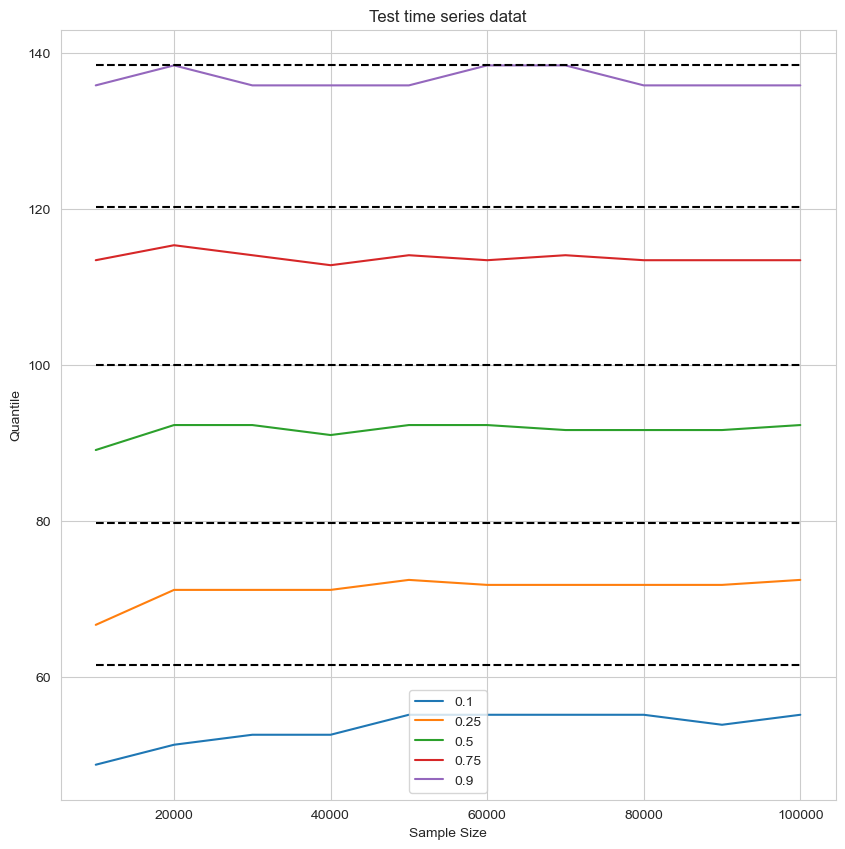

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.plot(sizes, answers)
for q in quantiles:
    plt.plot(np.array(sizes), np.full(shape= len(sizes), fill_value= stats.norm.ppf(q, mu, sigma)), label = 'Inverse CDF', color = 'black', linestyle = '--')
ax.set_xlabel('Sample Size')
ax.set_ylabel('Quantile')
ax.set_title('Test time series datat')
ax.legend(quantiles)

Report:

Q-digest is a data structure used for compactly representing the frequency distribution of a set of integer values. Q-digest represents the data in  tree-like structure where each node corresponds to a range of values and contains a count of the number of values falling in that range. The q-digest allows for the trade-off between space and accuracy by adjusting the compression parameter, which determines the maximum number of a buckets.

To construct the q-digest, we first create a leaf node for each integer value in the range [1,σ], where σ is the largest integer observed. We then merge adjacent leaf nodes pairwise to create level-1 nodes, and continue this process until we reach a single root node. At each level of the tree, we apply the COMPRESS algorithm if the nodes do not satisfy the conditions:


*   count(v) ≤ floor(n/k),
*   count(v) + count(vp) + count(vs) > floor(n/k)

The only exception to this property are the root and leaf nodes.
If a leaf’s frequency is larger than floor(n/k) then too it belongs to the
q-digest. And since there are no parent and sibling for root, its can
violate property 2 and still belong to the q-digest[1]

To find the qth quantile from a q-digest, the nodes of the q-digest are sorted in increasing right endpoints, and the counts of the nodes are added in a post-order traversal until the sum becomes more than qn, at which point the maximum value of the current node is reported as the estimate of the quantile. 

One limitation of the q-digest is that it loses detailed information about infrequent integers, which are grouped together into larger bins. However, it provides an accurate representation of the distribution for frequent integers, which are represented by smaller bins with low error. The compression parameter k determines the trade-off between accuracy and size, with larger values of k resulting in smaller digests with higher error.

[1] https://graphics.stanford.edu/courses/cs468-05-winter/Papers/Information_Aggregation/Suri_sensys04.pdf





- [ ] Submit to Moodle!